# Duration analysis by user general

In [30]:
import sqlite3
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pingouin as pg
from statsmodels.stats.anova import AnovaRM
from scipy.stats import zscore
from scipy.stats import shapiro
from scipy.stats import probplot
from tabulate import tabulate


conn = sqlite3.connect(
    r"C:\Users\max-j\OneDrive\Desktop\Bachelorarbeit_Auswertung\Datenbanken\Auswertung\app_database_2")

queryDataCombinedAvg = """SELECT
*,
(((TestCaseData.ObjectDistanceToTarget-DistanceFinished)/(Duration/1000)) * 10) AS PerformanceGeneral
FROM TestCaseData;""" #even value of testCases around the user

observed_group = 'UserID'
tested_variable = 'PerformanceGeneral'

DataCombinedAvg = pd.read_sql_query(queryDataCombinedAvg, conn)
DataCombinedAvgAggregated = DataCombinedAvg.groupby([observed_group, 'ScenarioCase'])[['Duration', 'PerformanceGeneral','DistanceFinished']].mean().reset_index()

DataCombinedAvgAggregated[f'{tested_variable}_z_within'] = DataCombinedAvgAggregated.groupby('ScenarioCase')[tested_variable].transform(zscore)

for data in DataCombinedAvgAggregated[f'{tested_variable}_z_within']:
    if data >= 2.5 or data <= -2.5:
        print(f"Significant outlier {data}")

    ScenarioCase  count      mean       std       min       25%       50%  \
0         FOLDAR   12.0  1.959344  0.709586  0.980396  1.422573  1.805603   
1     FOLDAROPEN   12.0  1.639961  0.673283  0.710557  1.202902  1.473284   
2  STATEOFTHEART   12.0  1.553431  0.564646  0.861235  1.039418  1.495905   

        75%       max  Duration  
0  2.367063  3.155965  23964.15  
1  2.050965  2.872448  31444.30  
2  1.852041  2.670382  29797.60  


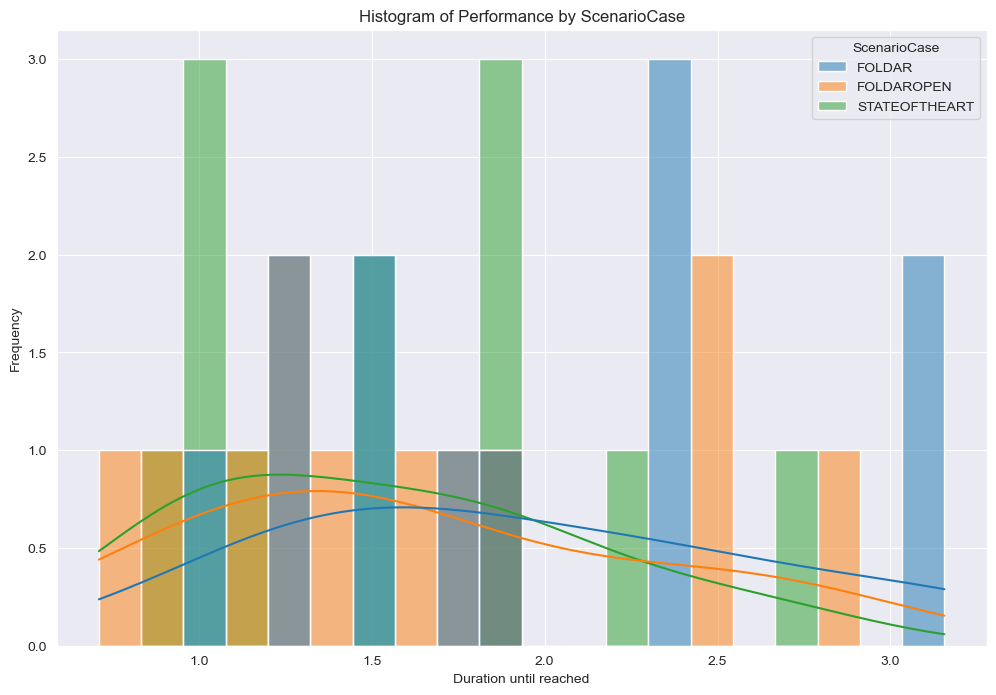

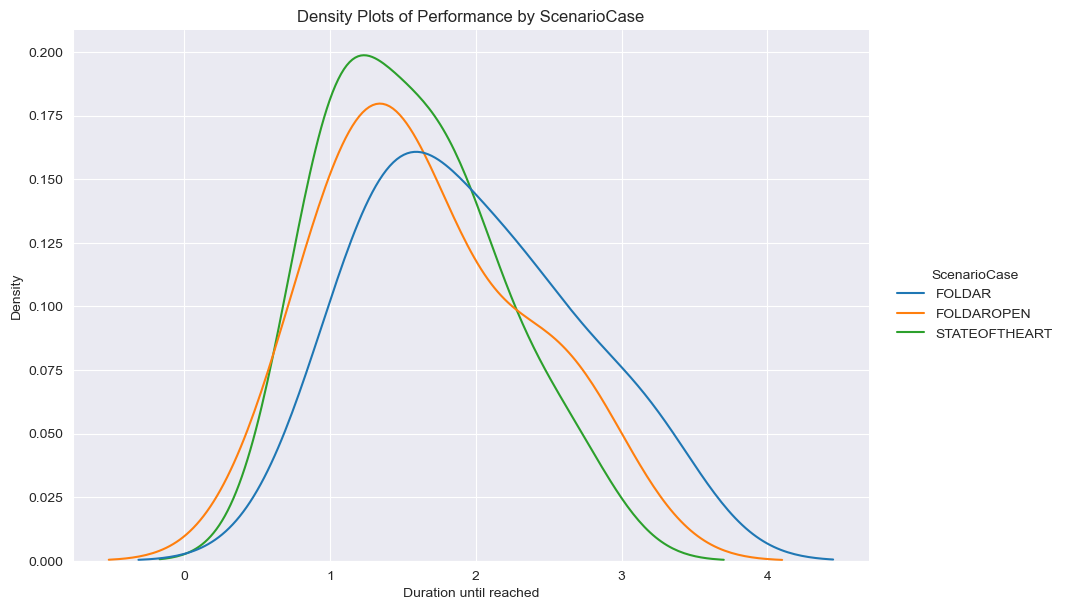

In [31]:
#Average duration for each scenario
summary_stats = DataCombinedAvgAggregated.groupby('ScenarioCase')[tested_variable].describe()
DataUserScenario = DataCombinedAvgAggregated.groupby('ScenarioCase')[["Duration"]].mean().reset_index()
# Falls summary_stats den Index "ScenarioCase" hat,
# setze bei DataUserScenario "ScenarioCase" als Schlüssel.
combined_output = pd.merge(
    summary_stats.reset_index(),  # falls summary_stats als Index ScenarioCase hat
    DataUserScenario,
    on='ScenarioCase',
    how='outer'
)
print(combined_output)

plt.figure(figsize=(12, 8))
sns.histplot(data=DataCombinedAvgAggregated, x=tested_variable, hue="ScenarioCase", kde=True, bins=20, alpha=0.5)
plt.title('Histogram of Performance by ScenarioCase')
plt.xlabel("Duration until reached")
plt.ylabel("Frequency")
plt.show()

sns.displot(data=DataCombinedAvgAggregated, x=tested_variable, hue='ScenarioCase', kind="kde", height=6, aspect=1.5)
plt.title("Density Plots of Performance by ScenarioCase")
plt.xlabel("Duration until reached")
plt.ylabel("Density")
plt.show()

# Check for normality

Shapiro-Wilk Normality Test Results per ScenarioCase:
Scenario: FOLDAR          | Shapiro-Wilk Statistic: 0.932178166084 | p-value: 0.403772453403
Scenario: FOLDAROPEN      | Shapiro-Wilk Statistic: 0.944480246336 | p-value: 0.558188320154
Scenario: STATEOFTHEART   | Shapiro-Wilk Statistic: 0.923429383617 | p-value: 0.315614497433


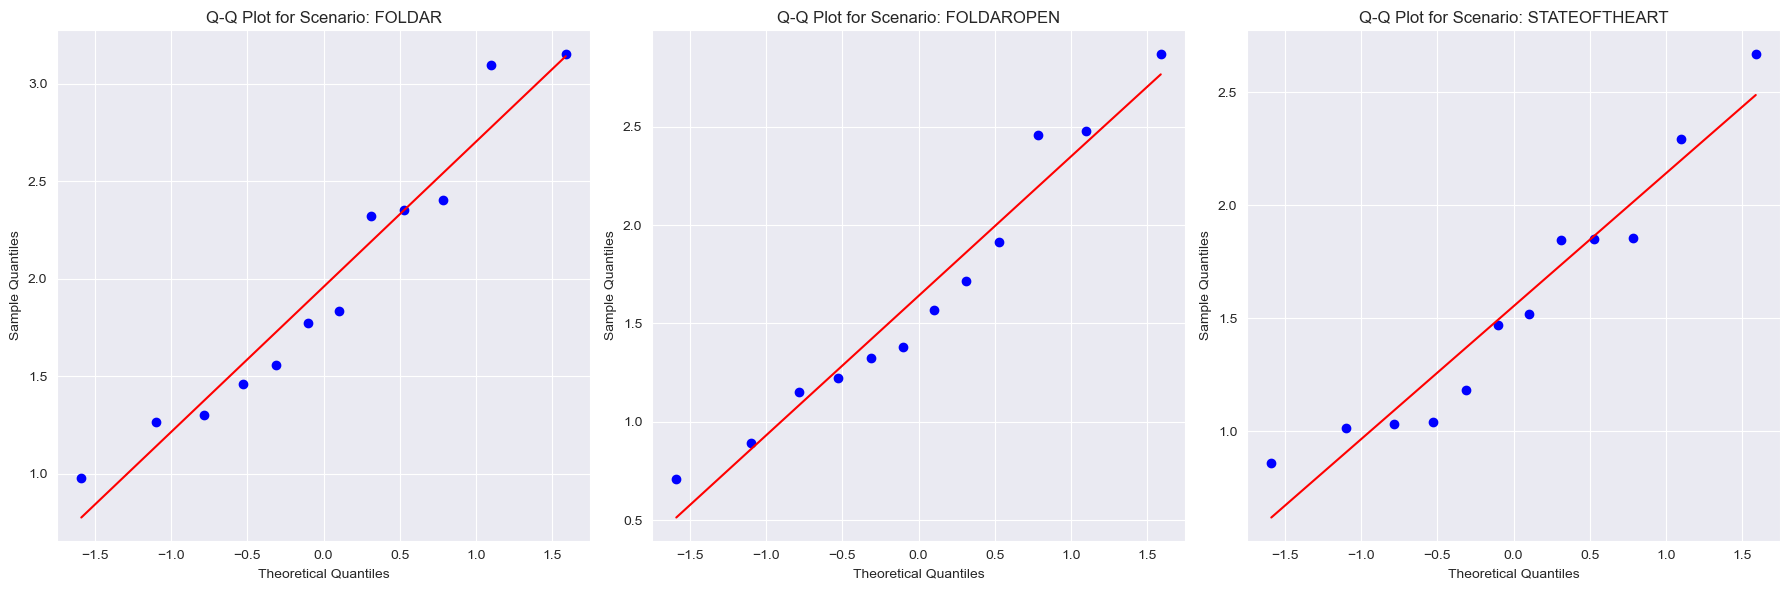

In [32]:
print("Shapiro-Wilk Normality Test Results per ScenarioCase:")
for scenario in DataCombinedAvgAggregated['ScenarioCase'].unique():
    data_scenario = DataCombinedAvgAggregated.loc[DataCombinedAvgAggregated['ScenarioCase'] == scenario, tested_variable]
    stat, p_value = shapiro(data_scenario)
    print(f"Scenario: {scenario:<15} | Shapiro-Wilk Statistic: {stat:.12f} | p-value: {p_value:.12f}")

# Get unique scenarios
scenarios = DataCombinedAvgAggregated['ScenarioCase'].unique()
n_scenarios = len(scenarios)

# Create a subplot grid. For example, one row with n_scenarios columns:
fig, axs = plt.subplots(1, n_scenarios, figsize=(6 * n_scenarios, 6))

# In case there's only one scenario, wrap the ax in a list
if n_scenarios == 1:
    axs = [axs]

# Loop over each scenario and respective subplot axis
for ax, scenario in zip(axs, scenarios):
    data_to_plot = DataCombinedAvgAggregated.loc[DataCombinedAvgAggregated['ScenarioCase'] == scenario, tested_variable]
    probplot(data_to_plot, dist="norm", plot=ax)
    ax.set_title(f"Q-Q Plot for Scenario: {scenario}")
    ax.set_xlabel("Theoretical Quantiles")
    ax.set_ylabel("Sample Quantiles")

plt.tight_layout()
plt.show()



# Mauchlys Test

In [33]:
sphericity_results = pg.sphericity(DataCombinedAvgAggregated, dv=tested_variable, within='ScenarioCase', subject=observed_group, method='mauchly',alpha=0.05)

header = f"{'Spher':<10} {'W':<15} {'Chi2':<15} {'Dof':<10} {'P-Value':<15}"
print("\nMauchly's Test for Sphericity Results:")
print(header)
print("-" * len(header))

row = f"{str(sphericity_results.spher):<10} " \
      f"{sphericity_results.W:<15.6f} " \
      f"{sphericity_results.chi2:<15.6f} " \
      f"{sphericity_results.dof:<10} " \
      f"{sphericity_results.pval:<15.6f}"
print(row)


Mauchly's Test for Sphericity Results:
Spher      W               Chi2            Dof        P-Value        
---------------------------------------------------------------------
False      0.352142        10.437219       2          0.005415       


# Repeated Anova


Repeated Measures ANOVA Results:

+--------------+---------+------+----------+-----------+-------------+-------------+-------------+------------+--------------+------------+--------------+
| Source       |      SS |   DF |       MS |         F |       p-unc |   p-GG-corr |         ng2 |        eps |   sphericity |    W-spher |      p-spher |
|--------------+---------+------+----------+-----------+-------------+-------------+-------------+------------+--------------+------------+--------------|
| ScenarioCase | 1.09703 |    2 | 0.548516 |   2.65311 |   0.0928482 |    0.122699 |   0.0725111 |   0.606848 |            0 |   0.352142 |   0.00541485 |
| Error        | 4.54838 |   22 | 0.206745 | nan       | nan         |  nan        | nan         | nan        |          nan | nan        | nan          |
+--------------+---------+------+----------+-----------+-------------+-------------+-------------+------------+--------------+------------+--------------+


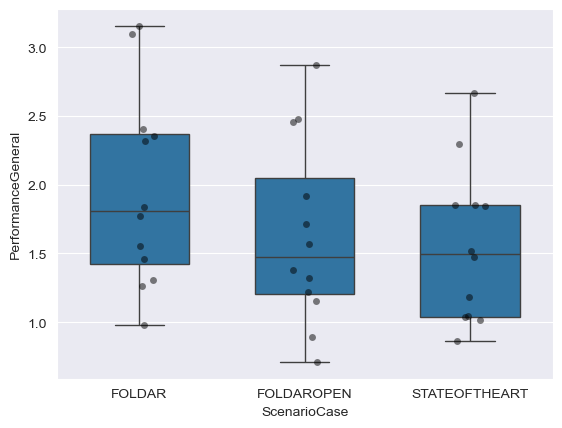

In [34]:
rm_anova = pg.rm_anova(data=DataCombinedAvgAggregated,
                       dv=tested_variable,
                       subject=observed_group,
                       within=['ScenarioCase'],
                       detailed=True)

# Print results
print("\nRepeated Measures ANOVA Results:\n")
print(tabulate(rm_anova, headers='keys', tablefmt='psql', showindex=False))

sns.boxplot(data=DataCombinedAvgAggregated, x='ScenarioCase', y=tested_variable, width=0.6, showfliers=False)
sns.stripplot(data=DataCombinedAvgAggregated, x='ScenarioCase', y=tested_variable, color='black', alpha=0.5)
plt.show()